In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    train=True,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
train_nshuffle_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_5_4', 'ctfdeconvolved'), ('TS_5_4', 'wbp'), ('TS_5_4', 'isonetcorrected'), ('TS_73_6', 'denoised'), ('TS_73_6', 'ctfdeconvolved'), ('TS_73_6', 'wbp'), ('TS_73_6', 'isonetcorrected'), ('TS_99_9', 'denoised'), ('TS_99_9', 'ctfdeconvolved'), ('TS_99_9', 'wbp'), ('TS_99_9', 'isonetcorrected'), ('TS_6_4', 'denoised'), ('TS_6_4', 'ctfdeconvolved'), ('TS_6_4', 'wbp'), ('TS_6_4', 'isonetcorrected'), ('TS_69_2', 'denoised'), ('TS_69_2', 'ctfdeconvolved'), ('TS_69_2', 'wbp'), ('TS_69_2', 'isonetcorrected')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/20 [00:00<?, ?it/s]


92

In [3]:
# torchのpadding用の関数
# torch.Size([4, 1, 158, 158]) -> torch.Size([4, 1, 160, 160])


class PadToSize(nn.Module):
    def __init__(self, resolution):
        super().__init__()
        if resolution == "0":
            self.size = 640
        elif resolution == "1":
            self.size = 320
        elif resolution == "2":
            self.size = 160

    def forward(self, x):
        return F.pad(x, (0, 0, self.size - x.shape[-1], self.size - x.shape[-2]))


# test
pad = PadToSize(CFG.resolution)
test_input = torch.randn((4, 1, 158, 158))
print(test_input.shape)
print(pad(test_input).shape)

torch.Size([4, 1, 158, 158])
torch.Size([4, 1, 320, 320])


In [4]:
model = UNet_2D().to("cuda")
model.eval()

UNet_2D(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [6]:
class SegmentationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.criterion = criterion

    def forward(self, output, target):
        # output: (batch, cls, 160, 160)
        # target: (batch, 160, 160)

        # output, (batch, 160, 160, cls) -> (batch, 160, 160, cls)
        output = output.permute(0, 2, 3, 1)
        output = output.reshape(-1, output.shape[-1])  # (batch*160*160, cls)

        # target, (batch, 160, 160) -> (batch*160*160)
        target = target.reshape(-1)

        loss = self.criterion(output, target)
        return loss


import torch
import torch.nn as nn
import torch.nn.functional as F


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, output, target):
        """
        output: (batch, cls, height, width)
        target: (batch, height, width)
        """
        # Apply softmax to get probabilities
        output = F.softmax(output, dim=1)

        # One-hot encode the target to match the number of classes in output
        num_classes = output.shape[1]
        target_one_hot = (
            F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()
        )

        # Flatten for Dice calculation
        output_flat = output.reshape(output.shape[0], output.shape[1], -1)
        target_flat = target_one_hot.reshape(
            target_one_hot.shape[0], target_one_hot.shape[1], -1
        )

        # Compute intersection and union
        intersection = (output_flat * target_flat).sum(dim=2)
        union = output_flat.sum(dim=2) + target_flat.sum(dim=2)

        # Compute Dice score
        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Average over classes and batch
        dice_loss = 1.0 - dice_score.mean()

        return dice_loss

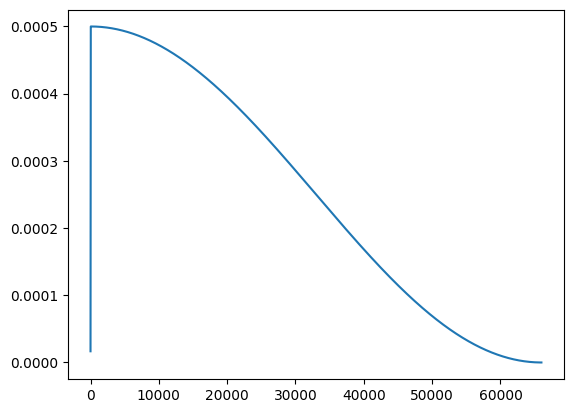

In [7]:
from transformers import get_cosine_schedule_with_warmup

n_epochs = 300
batch_size = 8

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=n_epochs // 10,
    num_training_steps=n_epochs
    * len(train_loader)
    * (normalized_tomogram.shape[0] // batch_size),
    # * batch_size,
)

criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
seg_loss = SegmentationLoss(criterion)

# criterion = DiceLoss()
# seg_loss = SegmentationLoss(criterion=criterion)

padf = PadToSize(CFG.resolution)

# schedulerのlr推移の可視化
lr_list = []

for epoch in range(
    n_epochs * len(train_loader) * (normalized_tomogram.shape[0] // batch_size)
):
    scheduler.step()
    lr_list.append(optimizer.param_groups[0]["lr"])

plt.plot(lr_list)

# del scheduler, lr_list, optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=n_epochs // 10,
    num_training_steps=n_epochs
    * len(train_loader)
    * (normalized_tomogram.shape[0] // batch_size),
)

In [8]:
best_model = None
best_score = 0

for epoch in range(100):
    train_loss = []
    train_nshuffle_loss = []
    valid_loss = []

    # train_original_tomogram = defaultdict(list)
    ##train_pred_tomogram = defaultdict(list)
    # train_gt_tomogram = defaultdict(list)

    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"]

        tomogram = tomogram.reshape(1, -1, tomogram.shape[-2], tomogram.shape[-1])
        segmentation_map = segmentation_map.reshape(
            1, -1, segmentation_map.shape[-2], segmentation_map.shape[-1]
        )

        random_index = torch.randperm(tomogram.shape[1])

        for i in range(0, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            input_ = (
                tomogram[:, random_index[i : i + batch_size]].to("cuda").transpose(0, 1)
            )
            gt = (
                segmentation_map[:, random_index[i : i + batch_size]]
                .to("cuda")
                .long()
                .squeeze()
            )
            # print(input_.shape, gt.shape)

            input_ = padf(input_)
            gt = padf(gt)
            input_, gt = aug(input_, gt)
            output = model(input_)
            loss = seg_loss(output, gt)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            # train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            # train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    train_exp_name = exp_name

    ######################################## train-nshuffle #########################################
    model.eval()
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_nshuffle_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            train_nshuffle_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_nshuffle_loss)}"
            )
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_nshuffle_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_nshuffle_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_, train_score_list = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(
        f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}, TRAIN_SCORE_LIST: {train_score_list}"
    )

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        valid_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    valid_exp_name = exp_name

    valid_score_, valid_score_list = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )

    print(
        f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}, VALID_SCORE_LIST: {valid_score_list}"
    )
    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 描画
    index = 30
    plt.figure(figsize=(20, 5))

    # Train-Pred-Plot
    ax = plt.subplot(1, 4, 1)
    pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred,
        "Train-Prediction",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Train-GT-Plot
    ax = plt.subplot(1, 4, 2)
    gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]
    plot_with_colormap(
        gt,
        "Train-Ground Truth",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Valid-Pred-Plot
    ax = plt.subplot(1, 4, 3)
    pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
    )

    # Valid-GT-Plot
    ax = plt.subplot(1, 4, 4)
    gt = valid_gt_tomogram[valid_exp_name][index][0]
    plot_with_colormap(
        gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
    )

    # 凡例を追加
    legend_elements = [
        Patch(facecolor=colors[i], label=CFG.particles_name[i])
        for i in range(1, num_classes)
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper right",
        title="particle",
        bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
        borderaxespad=0,
    )

    plt.tight_layout()
    plt.show()

  0%|          | 0/230 [00:00<?, ?it/s]

RuntimeError: Wrong input shape height=325, width=315. Expected image height and width divisible by 32. Consider pad your images to shape (352, 320).

In [9]:
tomogram.shape

torch.Size([1, 92, 315, 315])

In [11]:
padf(tomogram.squeeze(0)).shape

torch.Size([92, 325, 315])